## Algoritmo LSTM

In [1]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten


In [2]:
nombre_csv = 1
de = pd.read_csv(f'Datos_entrenamiento2/{nombre_csv}_e.csv')
dp = pd.read_csv(f'Datos_prueba2/{nombre_csv}_p.csv')

# Procesamiento

In [3]:
# Contamos las ocurrencias de cada nivel de estrés en la nueva columna
conteo_nivel_estresde = de['nivel_estres'].value_counts()
conteo_nivel_estresdp = dp['nivel_estres'].value_counts()
# Mostramos el resultado
print(conteo_nivel_estresde)
print(conteo_nivel_estresdp)

nivel_estres
normal     3342
alerta      391
peligro     179
Name: count, dtype: int64
nivel_estres
normal     2114
alerta      255
peligro     103
Name: count, dtype: int64


In [4]:
# Crear un diccionario para mapear cada categoría única en la columna 'nivel_estres' a un número
mapping = {'normal': 0, 'alerta': 1, 'peligro': 2}
# Mapear las categorías a números utilizando el método map de pandas
de['nivel_estres'] = de['nivel_estres'].map(mapping)
dp['nivel_estres'] = dp['nivel_estres'].map(mapping)


# ALGORITMO DE CNN+LSTM

In [5]:
# Separar características y etiquetas del conjunto de entrenamiento
X_train = de[['period eating','period other','period resting','period rumination']]
y_train = de['nivel_estres']
# Separar características y etiquetas del conjunto de prueba
X_test = dp[['period eating','period other','period resting','period rumination']]
y_test = dp['nivel_estres']

In [6]:
# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
#Expandir a 24 horas de datos para capturar ciclo diario
timesteps = 24
X_train_reshaped = np.array([X_train_scaled[i:i + timesteps] for i in range(len(X_train_scaled) - timesteps)])
y_train = y_train[timesteps:]
X_test_reshaped = np.array([X_test_scaled[i:i + timesteps] for i in range(len(X_test_scaled) - timesteps)])
y_test = y_test[timesteps:]

In [8]:
#Ajuste de pesos: Calcular pesos de clase para manejar el desbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
#class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
class_weights_dict = dict(enumerate(class_weights))

In [9]:
# Convertir etiquetas a formato categórico
y_train_categorical = to_categorical(y_train, num_classes=3)
y_test_categorical = to_categorical(y_test, num_classes=3)

In [10]:
# Construir el modelo CNN-LSTM
model = Sequential()
model.add(Conv1D(36, 3, activation='relu', input_shape=(timesteps, X_train_scaled.shape[1])))
model.add(MaxPooling1D(2))
model.add(LSTM(216, activation='relu', return_sequences=True))
model.add(LSTM(108, activation='relu'))
model.add(Dense(36, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])

# Entrenar el modelo
model.fit(X_train_reshaped, y_train_categorical, epochs=100, batch_size=36,
          validation_data=(X_test_reshaped, y_test_categorical), class_weight=class_weights_dict)



C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4236 - accuracy: 0.2144 - loss: 1.1303 - val_AUC: 0.7658 - val_accuracy: 0.7353 - val_loss: 1.0693
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.7210 - accuracy: 0.6563 - loss: 1.0849 - val_AUC: 0.8712 - val_accuracy: 0.8068 - val_loss: 1.0696
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 0.4273 - accuracy: 0.3659 - loss: 1.1371 - val_AUC: 0.8786 - val_accuracy: 0.7998 - val_loss: 0.9904
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - AUC: 0.6221 - accuracy: 0.5315 - loss: 1.0566 - val_AUC: 0.8947 - val_accuracy: 0.8264 - val_loss: 0.9829
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.6934 - accuracy: 0.6129 - loss: 1.0535 - val_AUC: 0.5764 - val_accuracy: 0.3321 - val_loss: 1.0753
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - AUC: 0.6006 - accuracy: 0.4752 - loss: 1.0346 - val_AUC: 0.9030 - val_accuracy: 0.8444 - val_loss: 0.8944
Epoch 7/100
108/108 ━━━━━━━━

In [11]:
# Predecir las etiquetas para el conjunto de prueba
y_pred_proba = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_proba, axis=1)
# Contamos las ocurrencias de cada nivel de estrés
valores_unicos, conteos = np.unique(y_test, return_counts=True)
valores_unicos1, conteos1 = np.unique(y_pred, return_counts=True)
# Combina los valores únicos y sus conteos en un diccionario para facilitar la visualización
ocurrencias = dict(zip(valores_unicos, conteos))
ocurrenciaspre = dict(zip(valores_unicos1, conteos1))
# Mostramos el resultado
#print(conteo_nivel_estres)
print(ocurrencias)
print(ocurrenciaspre)

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
{0: 2098, 1: 251, 2: 99}
{0: 2295, 1: 112, 2: 41}


# EVALUACION DEL ALGORITMO

In [12]:
test_loss,test_acuracy , test_auc = model.evaluate(X_test_reshaped, y_test_categorical)
print(f"Acuracy: {test_acuracy}")
print(f"AUC en prueba: {test_auc}")

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8956 - accuracy: 0.8296 - loss: 2.5777
Acuracy: 0.8080065250396729
AUC en prueba: 0.8766908049583435


In [13]:
# EVALUACION DEL MODELO
from sklearn.preprocessing import label_binarize
y_pred2 = label_binarize(y_pred, classes=[0, 1, 2])
# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
# Calcular el AUC
roc_auc = roc_auc_score(y_test_categorical, y_pred_proba, multi_class='ovo')

# Mostrar métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.8080065359477124
Precision: 0.7446815638307859
Recall: 0.8080065359477124
F1 Score: 0.7737071899129138
ROC AUC: 0.518876242096845


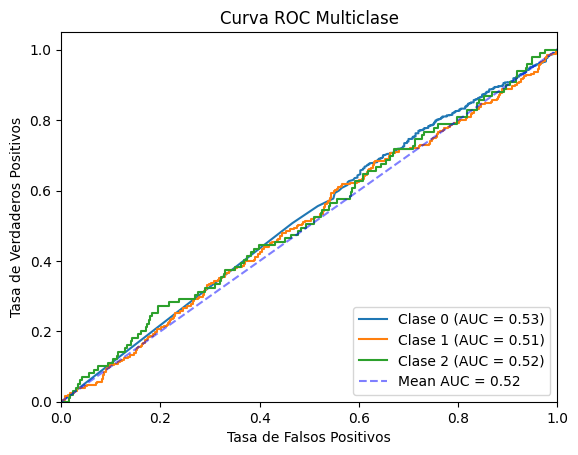

In [14]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_categorical[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar las curvas ROC
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

# Extraer los valores
values = roc_auc.values()
# Calcular la media
mean_auc = sum(values) / len(values)

plt.plot([0, 1], [0, 1], 'b--', label=f"Mean AUC = {mean_auc:.2f}", alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Multiclase')
plt.legend(loc='lower right')
#plt.savefig(f'../Curva_Roc/{nombre_csv}_roc_LSTM.png', format='png', dpi=300)
plt.show()